In [1]:
import numpy as np

from matplotlib import pyplot as plt

from numba import njit, prange

In [2]:
dt = .001
tau = .1
noise_tau = .002
dur = 10
bifurcate_time = .8
sgm = 10
threshold = 70
S = 500
R_initial = 32
eta = S*.1

In [29]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b, V_size):

    alpha = a

    beta = 0
    V_matrix = np.zeros(V_size)
    V_matrix.fill(S)

    omega_matrix = np.zeros((V_size, V_size))
    omega_matrix.fill(1)

    R_matrix = np.zeros((V_size, int(dur/dt)))
    G_matrix = np.zeros((V_size, int(dur/dt)))
    D_matrix = np.zeros((V_size, int(dur/dt)))

    R_matrix[:, 0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(np.sum(omega_matrix, axis=1)-beta))) / (2*(np.sum(omega_matrix, axis=1)-beta))
    G_matrix[:, 0] = (np.sum(omega_matrix, axis=1) - beta) * R_matrix[:, 0]
    D_matrix[:, 0] = beta * R_matrix[:, 0]

    noise_R = np.zeros((V_size, int(dur/dt)))
    noise_G = np.zeros((V_size, int(dur/dt)))
    noise_D = np.zeros((V_size, int(dur/dt)))

    rep = 10240
    reaction_time = np.zeros(rep)
    choice = np.zeros(rep)

    for i in prange(rep):

        beta = 0
        V_matrix.fill(S)

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                beta = b
                V_matrix[0] = S * (1+coh)
                V_matrix[1:] = S * (1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V_matrix[0] = S * (1+coh) + np.random.randn() * eta
                V_matrix[1:] = S * (1-coh) + np.random.randn() * eta

            d_noise_R = (-noise_R[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noise_G = (-noise_G[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noise_D = (-noise_D[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R = (-R_matrix[:, ti-1] + (alpha * R_matrix[:, ti-1] + V_matrix) / (1+G_matrix[:, ti-1])) * dt/tau
            d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
            d_D = (-D_matrix[:, ti-1] + beta * R_matrix[:, ti-1]) * dt/tau

            noise_R[:, ti] = noise_R[:, ti-1] + d_noise_R
            noise_G[:, ti] = noise_G[:, ti-1] + d_noise_G
            noise_D[:, ti] = noise_D[:, ti-1] + d_noise_D

            R_matrix[:, ti] = np.maximum(R_matrix[:, ti-1] + d_R + noise_R[:, ti], 0)
            G_matrix[:, ti] = np.maximum(G_matrix[:, ti-1] + d_G + noise_G[:, ti], 0)
            D_matrix[:, ti] = np.maximum(D_matrix[:, ti-1] + d_D + noise_D[:, ti], 0)

            if R_matrix[0, ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif R_matrix[1, ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice

In [30]:
def get_RT_choice(a, b):
    RT, choice = np.zeros(50), np.zeros(50)
    for coh in range(50):
        cur_RT, cur_choice = ave_choice(coh / 100, a, b, 2)
        RT[coh], choice[coh] = np.nanmean(cur_RT)*dt, np.nanmean(cur_choice)
        print("\r[EPOCH]: %d" % coh, end='')
    print("\r", end='')
    return RT, choice

In [31]:
rt1, cho1 = get_RT_choice(25, 1.2)
rt2, cho2 = get_RT_choice(25, 1.7)

C:\Users\weiyi\AppData\Local\Temp\ipykernel_24840\2333509173.py:50: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
C:\Users\weiyi\AppData\Local\Temp\ipykernel_24840\2333509173.py:50: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
C:\Users\weiyi\anaconda3\envs\week4\lib\site-packages\numba\core\typing\npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


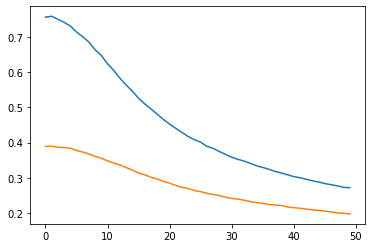

In [32]:
plt.plot(rt1)
plt.plot(rt2)
plt.show()

[0.4921875  0.54335937 0.60039062 0.64238281 0.68994141 0.73554688
 0.77509766 0.80986328 0.83789062 0.86132812 0.89853516 0.92167969
 0.93359375 0.94931641 0.96376953 0.97041016 0.97626953 0.98144531
 0.98955078 0.99140625 0.99277344 0.99677734 0.99667969 0.99863281
 0.99824219 0.99804688 0.99912109 0.99980469 0.99990234 0.99980469
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99990234 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


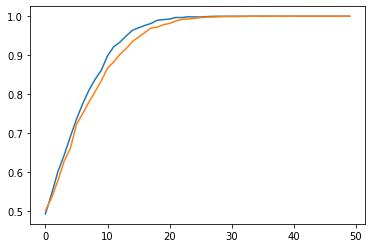

In [33]:
plt.plot(cho1)
plt.plot(cho2)
plt.show()